In [5]:
#Mount my drive- run the code, go to the link, accept.
from google.colab import drive
drive.mount('/content/gdrive')

#Change working directory to make it easier to access the files
import os
os.chdir("/content/gdrive/My Drive/Colab Notebooks/dinn")
os.getcwd() 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'/content/gdrive/My Drive/Colab Notebooks/dinn'

In [6]:
import torch
from torch.autograd import grad
import torch.nn as nn
from numpy import genfromtxt
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import math

pneumonia_data = genfromtxt('pneumonia.csv', delimiter=',') #in the form of [t, S ,V ,C ,I, R]

torch.manual_seed(1234)

In [7]:
%%time

PATH = 'pneumonia' 

class DINN(nn.Module):
    def __init__(self, t, S_data ,V_data ,C_data ,I_data, R_data):
        super(DINN, self).__init__()
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 
        self.S = torch.tensor(S_data)
        self.V = torch.tensor(V_data)
        self.C = torch.tensor(C_data)
        self.I = torch.tensor(I_data)
        self.R = torch.tensor(R_data)

        self.losses = [] #keep the losses
        self.save = 2 #which file to save to

        #learnable parameters
        self.pi_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(0.01)
        self.lambdda_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(0.1)
        self.k_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(0.5)
        self.epsilon_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(0.002)
        self.tao_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(0.89)
        self.phi_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(0.0025)
        self.chi_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(0.001)
        self.p_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(0.2)
        self.theta_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(0.008)
        self.mu_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(0.01)
        self.alpha_tilda= torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(0.057)
        self.rho_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(0.05)
        self.beta_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(0.0115)
        self.eta_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(0.2)
        self.q_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(0.5)
        self.delta_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(0.1)

        #matrices (x5 for S ,V ,C ,I, R) for the gradients
        self.m1 = torch.zeros((len(self.t), 5)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 5)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 5)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 5)); self.m4[:, 3] = 1
        self.m5 = torch.zeros((len(self.t), 5)); self.m5[:, 4] = 1

        #values for norm
        self.S_max = max(self.S)
        self.S_min = min(self.S)
        self.V_max = max(self.V)
        self.V_min = min(self.V)
        self.C_max = max(self.C)
        self.C_min = min(self.C)
        self.I_max = max(self.I)
        self.I_min = min(self.I)
        self.R_max = max(self.R)
        self.R_min = min(self.R)
        
        #normalize 
        self.S_hat = (self.S - self.S_min) / (self.S_max - self.S_min)
        self.V_hat = (self.V - self.V_min) / (self.V_max - self.V_min)
        self.C_hat = (self.C - self.C_min) / (self.C_max - self.C_min)
        self.I_hat = (self.I - self.I_min) / (self.I_max - self.I_min)
        self.R_hat = (self.R - self.R_min) / (self.R_max - self.R_min)

        #NN
        self.net_pneumonia = self.Net_pneumonia()
        self.params = list(self.net_pneumonia.parameters())
        self.params.extend(list([self.pi_tilda ,self.lambdda_tilda ,self.k_tilda ,self.epsilon_tilda ,self.tao_tilda ,self.phi_tilda ,self.chi_tilda ,self.p_tilda ,self.theta_tilda ,self.mu_tilda ,self.alpha_tilda , self.rho_tilda ,self.beta_tilda ,self.eta_tilda ,self.q_tilda ,self.delta_tilda]))

        
    #force parameters to be in a range
    @property
    def pi(self):
        return torch.tanh(self.pi_tilda) * 0.001 + 0.01
    @property
    def lambdda(self):
        return torch.tanh(self.lambdda_tilda) * 0.001 + 0.1
    @property
    def k(self):
        return torch.tanh(self.k_tilda) * 0.01 + 0.5
    @property
    def epsilon(self):
        return torch.tanh(self.epsilon_tilda) * 0.001 + 0.002
    @property
    def tao(self):
        return torch.tanh(self.tao_tilda) * 0.02 + 0.89
    @property
    def phi(self):
        return torch.tanh(self.phi_tilda) * 0.0002 + 0.0025
    @property
    def chi(self):
        return torch.tanh(self.chi_tilda) * 0.0001 + 0.001
    @property
    def p(self):
        return torch.tanh(self.p_tilda) * 0.01 + 0.2
    @property
    def theta(self):
        return torch.tanh(self.theta_tilda) * 0.0005 + 0.008
    @property
    def mu(self):
        return torch.tanh(self.mu_tilda) * 0.001 + 0.01
    @property
    def alpha(self):
        return torch.tanh(self.alpha_tilda) * 0.001 + 0.057
    @property
    def rho(self):
        return torch.tanh(self.rho_tilda) * 0.001 + 0.05
    @property
    def beta(self):
        return torch.tanh(self.beta_tilda) * 0.001 + 0.0115
    @property
    def eta(self):
        return torch.tanh(self.eta_tilda) * 0.01 + 0.2
    @property
    def q(self):
        return torch.tanh(self.q_tilda) * 0.01 + 0.5
    @property
    def delta(self):
        return torch.tanh(self.delta_tilda) * 0.01 + 0.1

    #nets
    class Net_pneumonia(nn.Module): # input = [t]
        def __init__(self):
            super(DINN.Net_pneumonia, self).__init__()
            self.fc1=nn.Linear(1, 64) #takes 100 t's
            self.fc2=nn.Linear(64, 64)
            self.fc3=nn.Linear(64, 64)
            self.fc4=nn.Linear(64, 64)
            self.fc5=nn.Linear(64, 64)
            self.fc6=nn.Linear(64, 64)
            self.fc7=nn.Linear(64, 64)
            self.fc8=nn.Linear(64, 64)
            self.out=nn.Linear(64, 5) #outputs S ,V ,C ,I, R

        def forward(self, t):
            pneumonia=F.relu(self.fc1(t))
            pneumonia=F.relu(self.fc2(pneumonia))
            pneumonia=F.relu(self.fc3(pneumonia))
            pneumonia=F.relu(self.fc4(pneumonia))
            pneumonia=F.relu(self.fc5(pneumonia))
            pneumonia=F.relu(self.fc6(pneumonia))
            pneumonia=F.relu(self.fc7(pneumonia))
            pneumonia=F.relu(self.fc8(pneumonia))
            pneumonia=self.out(pneumonia)
            return pneumonia    

    def net_f(self, t_batch):       

        pneumonia_hat = self.net_pneumonia(t_batch)

        S_hat, V_hat, C_hat, I_hat, R_hat = pneumonia_hat[:,0], pneumonia_hat[:,1], pneumonia_hat[:,2], pneumonia_hat[:,3], pneumonia_hat[:,4]

        #S_hat
        pneumonia_hat.backward(self.m1, retain_graph=True)
        S_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #V_hat
        pneumonia_hat.backward(self.m2, retain_graph=True)
        V_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #C_hat
        pneumonia_hat.backward(self.m3, retain_graph=True)
        C_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #I_hat
        pneumonia_hat.backward(self.m4, retain_graph=True)
        I_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #R_hat
        pneumonia_hat.backward(self.m5, retain_graph=True)
        R_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #unnormalize
        S = self.S_min + (self.S_max - self.S_min) * S_hat
        V = self.V_min + (self.V_max - self.V_min) * V_hat
        C = self.C_min + (self.C_max - self.C_min) * C_hat
        I = self.I_min + (self.I_max - self.I_min) * I_hat
        R = self.R_min + (self.R_max - self.R_min) * R_hat
     
        #equations
        f1_hat = S_hat_t - ((1-self.p)*self.pi + self.phi*V + self.delta * R - (self.mu + self.lambdda + self.theta) * S) / (self.S_max - self.S_min) 
        f2_hat = V_hat_t - (self.p * self.pi + self.theta * S - (self.mu + self.epsilon * self.lambdda + self.phi) * V) / (self.V_max - self.V_min) 
        f3_hat = C_hat_t - (self.rho * self.lambdda * S + self.rho*self.epsilon*self.lambdda*V + (1-self.q) * self.eta * I - (self.mu + self.beta + self.chi) * C) / (self.C_max - self.C_min) 
        f4_hat = I_hat_t - ((1-self.rho)*self.lambdda * S + (1-self.rho)*self.epsilon*self.lambdda*V+self.chi*C-(self.mu+self.alpha+self.eta)*I) / (self.I_max - self.I_min) 
        f5_hat = R_hat_t - (self.beta * C + self.q*self.eta*I - (self.mu + self.delta)*R) / (self.R_max - self.R_min) 

        return f1_hat, f2_hat, f3_hat, f4_hat ,f5_hat,S_hat ,V_hat ,C_hat ,I_hat ,R_hat
    
    def load(self):
      # Load checkpoint
      try:
        checkpoint = torch.load(PATH + str(self.save)+'.pt') 
        print('\nloading pre-trained model...')
        self.load_state_dict(checkpoint['model'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        self.losses = checkpoint['losses']
        print('loaded previous loss: ', loss)
      except RuntimeError :
          print('changed the arself.chitecture, ignore')
          pass
      except FileNotFoundError:
          pass

    def train(self, n_epochs):
      #try loading
      self.load()

      #train
      print('\nstarting training...\n')
      
      for epoch in range(n_epochs):
        #lists to hold the output (maintain only the final epoch)
        S_pred_list = []
        V_pred_list = []
        C_pred_list = []
        I_pred_list = []
        R_pred_list = []

        f1_hat, f2_hat, f3_hat, f4_hat, f5_hat ,S_hat_pred ,V_hat_pred ,C_hat_pred ,I_hat_pred ,R_hat_pred = self.net_f(self.t_batch)
        self.optimizer.zero_grad()

        S_pred_list.append((self.S_min + (self.S_max - self.S_min) * S_hat_pred))
        V_pred_list.append((self.V_min + (self.V_max - self.V_min) * V_hat_pred))
        C_pred_list.append((self.C_min + (self.C_max - self.C_min) * C_hat_pred))
        I_pred_list.append((self.I_min + (self.I_max - self.I_min) * I_hat_pred))
        R_pred_list.append((self.R_min + (self.R_max - self.R_min) * R_hat_pred))

        loss = (
              torch.mean(torch.square(self.S_hat - S_hat_pred)) + torch.mean(torch.square(self.V_hat - V_hat_pred)) + 
              torch.mean(torch.square(self.C_hat - C_hat_pred)) + torch.mean(torch.square(self.I_hat - I_hat_pred)) +
              torch.mean(torch.square(self.R_hat - R_hat_pred)) +
              torch.mean(torch.square(f1_hat)) + torch.mean(torch.square(f2_hat)) +
              torch.mean(torch.square(f3_hat)) + torch.mean(torch.square(f4_hat)) +
              torch.mean(torch.square(f5_hat))
               )

        loss.backward()

        self.optimizer.step()
        self.scheduler.step() 
        #self.scheduler.step(loss) 

        self.losses.append(loss.item())

        if epoch % 1000 == 0:          
          print('\nEpoch ', epoch)

        #loss + model parameters update
        if epoch % 4000 == 0:
          #checkpoint save every 1000 epochs if the loss is lower
          print('\nSaving model... Loss is: ', loss)
          torch.save({
              'epoch': epoch,
              'model': self.state_dict(),
              'optimizer_state_dict': self.optimizer.state_dict(),
              'scheduler': self.scheduler.state_dict(),
              'loss': loss,
              'losses': self.losses,
              }, PATH + str(self.save)+'.pt')
          if self.save % 2 > 0: #its on 3
            self.save = 2 #change to 2
          else: #its on 2
            self.save = 3 #change to 3

          print('epoch: ', epoch)
          print(self.pi ,self.lambdda ,self.k ,self.epsilon ,self.tao ,self.phi ,self.chi ,self.p ,self.theta ,self.mu ,self.alpha , self.rho ,self.beta ,self.eta ,self.q ,self.delta)
          print('(0.01) ,(0.1) ,(0.5) ,(0.002) ,(0.89) ,(0.0025) ,(0.001) ,(0.2) ,(0.008) ,(0.01) ,(0.057) ,(0.05) ,(0.0115) ,(0.2) ,(0.5) ,(0.1)')
          # print('self.alpha1:self. (goal 1)', self.alpha1)self.
          # print('\nself.alpha2:self. (goal 0)', self.alpha2)self.
          # print('\nself.beta: (goal 0.0075): ', self.beta)
          # print('\nself.mu (goal 5): ', self.mu)
          # print('\nu: (goal 0.515151515): ', self.u)
          # print('\ntao (goal 0.58): ', self.tao)
          print('#################################')
        
      #plot
      plt.plot(self.losses, color = 'teal')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      return  S_pred_list , V_pred_list , C_pred_list , I_pred_list , R_pred_list

CPU times: user 88 µs, sys: 0 ns, total: 88 µs
Wall time: 95.1 µs



loading pre-trained model...
loaded previous loss:  tensor(0.0038, dtype=torch.float64, requires_grad=True)

starting training...


Epoch  0

Saving model... Loss is:  tensor(0.0038, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch:  0
tensor([0.0098], grad_fn=<AddBackward0>) tensor([0.0991], grad_fn=<AddBackward0>) tensor([0.5025], grad_fn=<AddBackward0>) tensor([0.0024], grad_fn=<AddBackward0>) tensor([0.8912], grad_fn=<AddBackward0>) tensor([0.0027], grad_fn=<AddBackward0>) tensor([0.0011], grad_fn=<AddBackward0>) tensor([0.2033], grad_fn=<AddBackward0>) tensor([0.0084], grad_fn=<AddBackward0>) tensor([0.0092], grad_fn=<AddBackward0>) tensor([0.0569], grad_fn=<AddBackward0>) tensor([0.0507], grad_fn=<AddBackward0>) tensor([0.0121], grad_fn=<AddBackward0>) tensor([0.2014], grad_fn=<AddBackward0>) tensor([0.4970], grad_fn=<AddBackward0>) tensor([0.1032], grad_fn=<AddBackward0>)
(0.01) ,(0.1) ,(0.5) ,(0.002) ,(0.89) ,(0.0025) ,(0.001) ,(0.2) ,(0.008) ,(0.01) ,(0.057) ,(0.05) ,(0.011

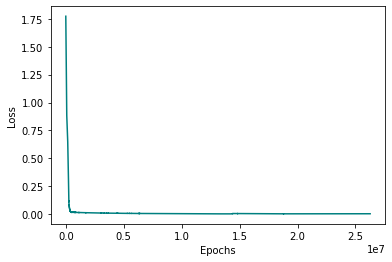

In [8]:
%%time

#this worked best
dinn = DINN(pneumonia_data[0], pneumonia_data[1], pneumonia_data[2], pneumonia_data[3], pneumonia_data[4], pneumonia_data[5])

learning_rate = 1e-3
optimizer = optim.Adam(dinn.params, lr = learning_rate)
dinn.optimizer = optimizer

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(dinn.optimizer, factor=0.85, patience = 5000, verbose=True)
#scheduler = torch.optim.lr_scheduler.CyclicLR(dinn.optimizer, base_lr=1e-6, max_lr=1e-3, step_size_up=1000, mode="triangular2", cycle_momentum=False)
scheduler = torch.optim.lr_scheduler.CyclicLR(dinn.optimizer, base_lr=1e-7, max_lr=1e-3, step_size_up=1000, mode="exp_range", gamma=0.85, cycle_momentum=False)

dinn.scheduler = scheduler

try: 
  S_pred_list , V_pred_list , C_pred_list , I_pred_list , R_pred_list = dinn.train(61) #train
except EOFError:
  if dinn.save == 2:
    dinn.save = 3
    S_pred_list , V_pred_list , C_pred_list , I_pred_list , R_pred_list = dinn.train(61) #train
  elif dinn.save == 3:
    dinn.save = 2
    S_pred_list , V_pred_list , C_pred_list , I_pred_list , R_pred_list = dinn.train(61) #train

Text(0, 0.5, 'Loss')

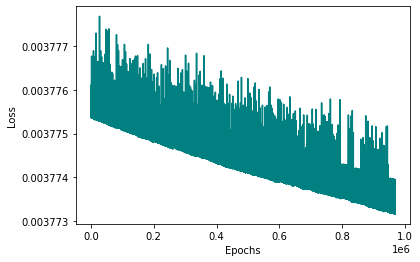

In [13]:
plt.plot(dinn.losses[25300000:], color = 'teal')
plt.xlabel('Epochs')
plt.ylabel('Loss')

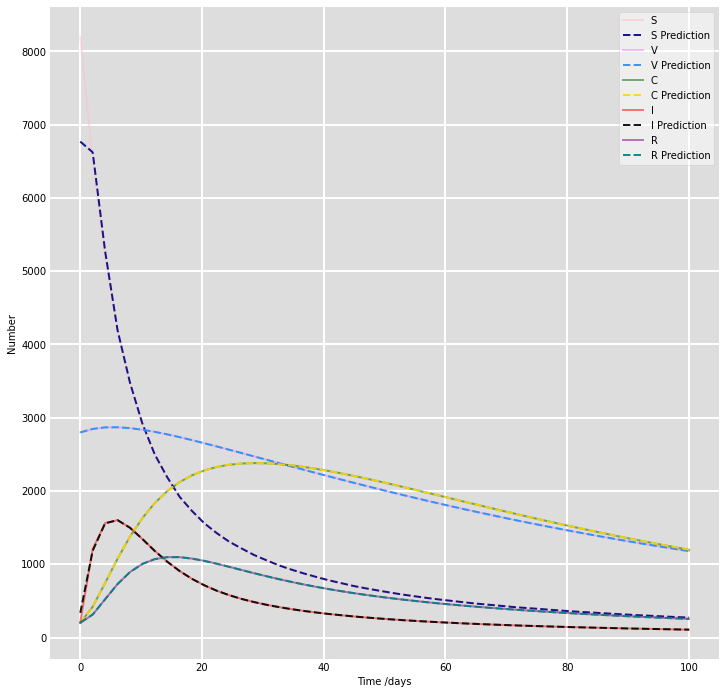

In [10]:
fig = plt.figure(facecolor='w', figsize=(12,12))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

ax.plot(pneumonia_data[0], pneumonia_data[1], 'pink', alpha=0.5, lw=2, label='S')
ax.plot(pneumonia_data[0], S_pred_list[0].detach().numpy(), 'navy', alpha=0.9, lw=2, label='S Prediction', linestyle='dashed')

ax.plot(pneumonia_data[0], pneumonia_data[2], 'violet', alpha=0.5, lw=2, label='V')
ax.plot(pneumonia_data[0], V_pred_list[0].detach().numpy(), 'dodgerblue', alpha=0.9, lw=2, label='V Prediction', linestyle='dashed')

ax.plot(pneumonia_data[0], pneumonia_data[3], 'darkgreen', alpha=0.5, lw=2, label='C')
ax.plot(pneumonia_data[0], C_pred_list[0].detach().numpy(), 'gold', alpha=0.9, lw=2, label='C Prediction', linestyle='dashed')

ax.plot(pneumonia_data[0], pneumonia_data[4], 'red', alpha=0.5, lw=2, label='I')
ax.plot(pneumonia_data[0], I_pred_list[0].detach().numpy(), 'black', alpha=0.9, lw=2, label='I Prediction', linestyle='dashed')

ax.plot(pneumonia_data[0], pneumonia_data[5], 'purple', alpha=0.5, lw=2, label='R')
ax.plot(pneumonia_data[0], R_pred_list[0].detach().numpy(), 'teal', alpha=0.9, lw=2, label='R Prediction', linestyle='dashed')

ax.set_xlabel('Time /days')
ax.set_ylabel('Number')
#ax.set_ylim([-1,50])
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

tensor([0.0098], grad_fn=<AddBackward0>)
tensor([0.0991], grad_fn=<AddBackward0>)
tensor([0.5025], grad_fn=<AddBackward0>)
tensor([0.0024], grad_fn=<AddBackward0>)
tensor([0.8912], grad_fn=<AddBackward0>)
tensor([0.0027], grad_fn=<AddBackward0>)
tensor([0.0011], grad_fn=<AddBackward0>)
tensor([0.2033], grad_fn=<AddBackward0>)
tensor([0.0084], grad_fn=<AddBackward0>)
tensor([0.0092], grad_fn=<AddBackward0>)
tensor([0.0569], grad_fn=<AddBackward0>)
tensor([0.0507], grad_fn=<AddBackward0>)
tensor([0.0121], grad_fn=<AddBackward0>)
tensor([0.2014], grad_fn=<AddBackward0>)
tensor([0.4970], grad_fn=<AddBackward0>)
tensor([0.1032], grad_fn=<AddBackward0>)


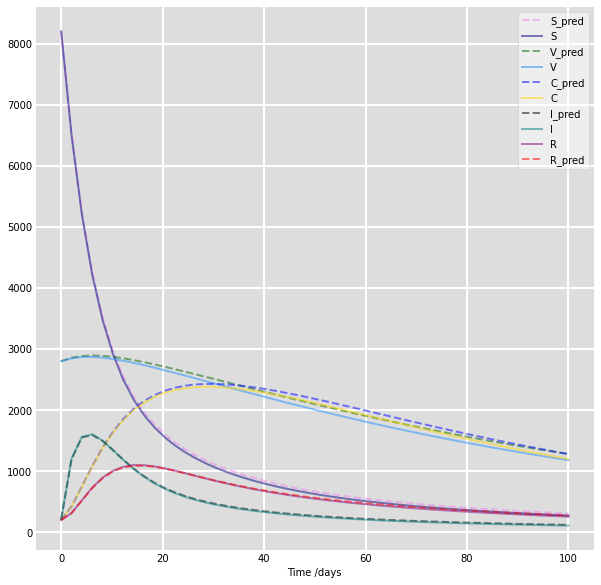

In [11]:
#vaccination! 

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Initial conditions
S0 = 8200
V0 = 2800 
C0 = 200 
I0 = 210
R0 = 200

# A grid of time points (in days)
t = np.linspace(0, 100, 50) 

#parameters
pi = dinn.pi
lambdda = dinn.lambdda
k = dinn.k
epsilon = dinn.epsilon
tao = dinn.tao
phi = dinn.phi
chi = dinn.chi
p = dinn.p
theta = dinn.theta
mu = dinn.mu
alpha = dinn.alpha
rho = dinn.rho
beta = dinn.beta
eta = dinn.eta
q = dinn.q
delta = dinn.delta


# The SIR model differential equations.
def deriv(y, t, pi, lambdda, k ,epsilon ,tao ,phi ,chi ,p ,theta ,mu ,alpha ,rho ,beta ,eta ,q ,delta):
    S ,V ,C ,I ,R = y

    dSdt = (1-p)*pi + phi*V + delta * R - (mu + lambdda + theta) * S
    dVdt = p * pi + theta * S - (mu + epsilon * lambdda + phi) * V
    dCdt = rho * lambdda * S + rho*epsilon*lambdda*V + (1-q) * eta * I - (mu + beta + chi) * C
    dIdt = (1-rho)*lambdda * S + (1-rho)*epsilon*lambdda*V+chi*C-(mu+alpha+eta)*I
    dRdt = beta * C + q*eta*I - (mu + delta)*R

    return dSdt  ,dVdt  ,dCdt  ,dIdt  ,dRdt 


# Initial conditions vector
y0 = S0 ,V0 ,C0 ,I0 ,R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(pi, lambdda, k ,epsilon ,tao ,phi ,chi ,p ,theta ,mu ,alpha ,rho ,beta ,eta ,q ,delta))
S ,V ,C ,I ,R  = ret.T

# Plot the data on two separate curves for S(t), I(t)
fig = plt.figure(facecolor='w', figsize=(10,10))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

ax.plot(t, S, 'violet', alpha=0.5, lw=2, label='S_pred', linestyle='dashed')
ax.plot(pneumonia_data[0], pneumonia_data[1], 'navy', alpha=0.5, lw=2, label='S')

ax.plot(t, V, 'darkgreen', alpha=0.5, lw=2, label='V_pred', linestyle='dashed')
ax.plot(pneumonia_data[0], pneumonia_data[2], 'dodgerblue', alpha=0.5, lw=2, label='V')

ax.plot(t, C, 'blue', alpha=0.5, lw=2, label='C_pred', linestyle='dashed')
ax.plot(pneumonia_data[0], pneumonia_data[3], 'gold', alpha=0.5, lw=2, label='C')

ax.plot(t, I, 'black', alpha=0.5, lw=2, label='I_pred', linestyle='dashed')
ax.plot(pneumonia_data[0], pneumonia_data[4], 'teal', alpha=0.5, lw=2, label='I')

ax.plot(pneumonia_data[0], pneumonia_data[5], 'purple', alpha=0.5, lw=2, label='R')
ax.plot(t, R, 'red', alpha=0.5, lw=2, label='R_pred', linestyle='dashed')


ax.set_xlabel('Time /days')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [18]:
#calculate relative MSE loss
import math

#SVCIR

S_total_loss = 0
S_den = 0
V_total_loss = 0
V_den = 0
C_total_loss = 0
C_den = 0
I_total_loss = 0
I_den = 0
R_total_loss = 0
R_den = 0

for timestep in range(len(t)):
  S_value = pneumonia_data[1][timestep] - S[timestep]
  S_total_loss += S_value**2
  S_den += (pneumonia_data[1][timestep])**2
  V_value = pneumonia_data[2][timestep] - V[timestep]
  V_total_loss += V_value**2
  V_den += (pneumonia_data[2][timestep])**2
  C_value = pneumonia_data[3][timestep] - C[timestep]
  C_total_loss += C_value**2
  C_den += (pneumonia_data[3][timestep])**2
  I_value = pneumonia_data[4][timestep] - I[timestep]
  I_total_loss += I_value**2
  I_den += (pneumonia_data[4][timestep])**2
  R_value = pneumonia_data[5][timestep] - R[timestep]
  R_total_loss += R_value**2
  R_den += (pneumonia_data[5][timestep])**2

S_total_loss = math.sqrt(S_total_loss/S_den)
V_total_loss = math.sqrt(V_total_loss/V_den)
C_total_loss = math.sqrt(C_total_loss/C_den)
I_total_loss = math.sqrt(I_total_loss/I_den)
R_total_loss = math.sqrt(R_total_loss/R_den)

print('S_total_loss: ', S_total_loss)
print('V_total_loss: ', V_total_loss)
print('C_total_loss: ', C_total_loss)
print('I_total_loss: ', I_total_loss)
print('R_total_loss: ', R_total_loss)

S_total_loss:  0.020262746338235514
V_total_loss:  0.03910885418654915
C_total_loss:  0.034445556996860104
I_total_loss:  0.019550813369984002
R_total_loss:  0.02323016583096909
